# Hand Pose estimation generalized to both Left and Right Hand

## 1. Classifier accuracy

Let's evaluate model accuracy in the Test Set.

Loading Test Set indexes.

In [1]:
from settings import DATA, PRC
from model.dataset import FreiHANDSplitter

split = FreiHANDSplitter(
    n=DATA["n_data"],
    percentages=list(PRC.values())
)

idxs = split.test_idx
len(idxs)

1560

Loading collection

In [2]:
from model.hand import HandCollection

collection = HandCollection()
collection

HandCollection

Loading classifier

In [3]:
from io_ import load_model
from settings import LEFT_RIGHT_MODEL_CONFIG
from model.left_hand import AlexNet

net = AlexNet(num_classes=2)

classifier = load_model(model=net, config=LEFT_RIGHT_MODEL_CONFIG)
classifier

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

Evaluate prediction over the training set (we assume it contains only right hand images)

In [4]:
from tqdm import tqdm
predictions = [not collection[i].predict_left_hand(model=classifier) for i in tqdm(idxs)]

100%|██████████| 1560/1560 [01:17<00:00, 20.02it/s]


In [5]:
accuracy = sum(predictions)/len(idxs)
accuracy

0.867948717948718

## 2. Inference over Left-hands

### Best predictions

We take the hands with the best prediction, we mirror them and finally evaluate the Hand-Pose estimation with the two models.

In [6]:
import numpy as np

from settings import LEFT_RIGHT_MODEL_CONFIG, HANDPOSE_MODEL_CONFIG
from io_ import read_json, get_errors_file
from model.left_hand import LeftHandCollectionInference

Select the best 10 predictions.

In [7]:
errors_dict = read_json(path_=get_errors_file(model_name=HANDPOSE_MODEL_CONFIG["model_name"]))
errors = list(errors_dict.values())
errors_argsort = np.argsort(errors)
best_10 = errors_argsort[:10]

In [8]:
left_hand_collection = LeftHandCollectionInference(classifier_config=LEFT_RIGHT_MODEL_CONFIG, estimator_config=HANDPOSE_MODEL_CONFIG)

INFO: Loading the model


In [9]:
from matplotlib import pyplot as plt


def model_comparison(idx: int):
    
    start, _ = split.test_bounds
    actual_idx = idx + start
    
    hand1, hand2 = left_hand_collection[actual_idx]

    print(f"Hand {hand1.idx}")
    print(f"No classification error: {hand1.mean_pixel_error}")
    print(f"With classification error: {hand2.mean_pixel_error}")
    
    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(7, 4))

    for ax, hand, title in zip([0, 1], [hand1, hand2], ["No classification", "With classification"]):

        axes[ax].imshow(hand.pred_skeleton)
        axes[ax].axis('off')
        axes[ax].set_title(title)

    # Add a title for both images
    plt.suptitle(f"{hand1.idx} - Comparison")
    plt.show()

Hand 31718
No classification error: 7.551264194341607
With classification error: 2.5423746043663504


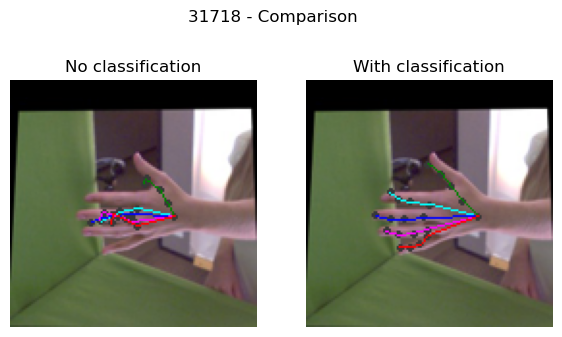

Hand 31332
No classification error: 15.852655845571146
With classification error: 15.852655845571146


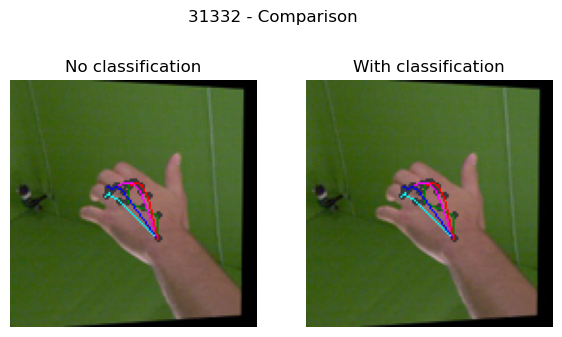

Hand 31744
No classification error: 4.099604804183976
With classification error: 3.250132542653749


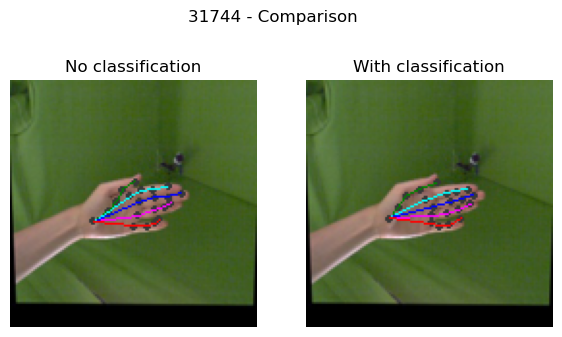

Hand 31642
No classification error: 6.806207611633159
With classification error: 2.699280958201019


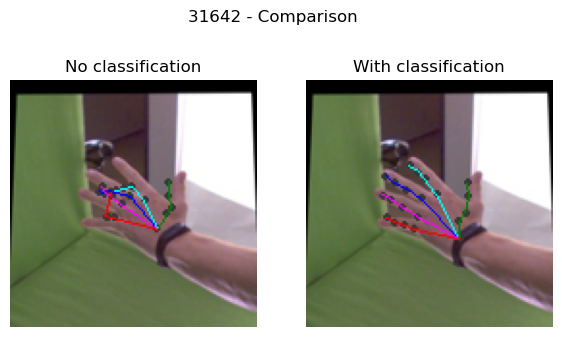

Hand 31294
No classification error: 16.98621010069865
With classification error: 3.0100362474070756


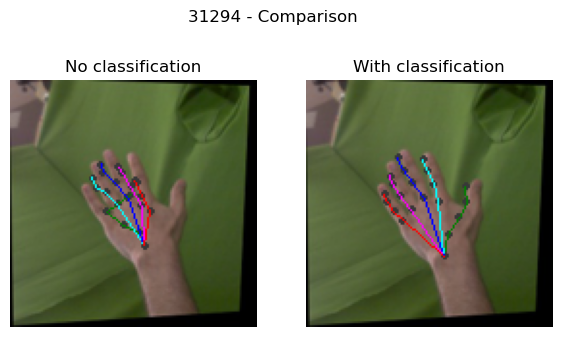

Hand 31050
No classification error: 13.168155322340827
With classification error: 3.681638385669922


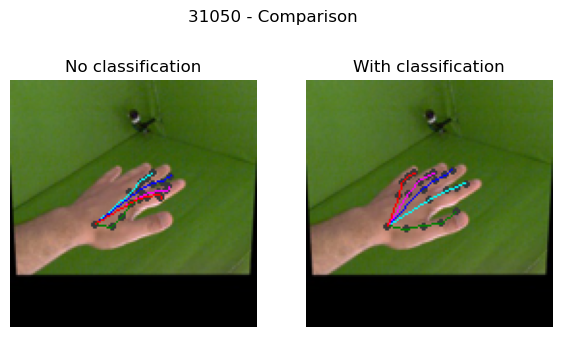

Hand 31590
No classification error: 11.253271317434724
With classification error: 2.8004812091762274


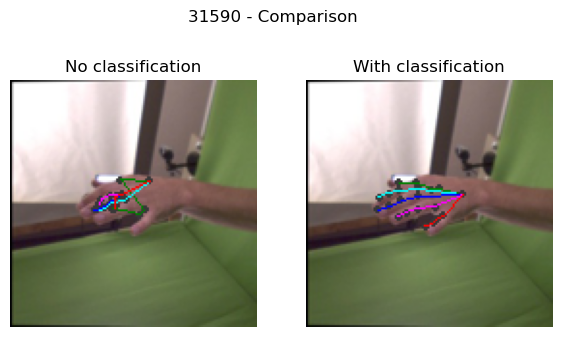

Hand 31978
No classification error: 14.04671284496366
With classification error: 3.698343222117616


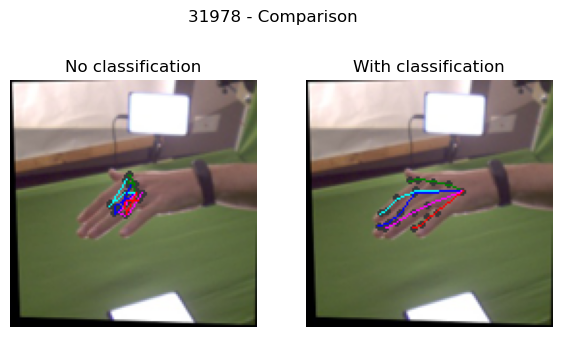

Hand 31628
No classification error: 10.569822447810393
With classification error: 3.6869628876124847


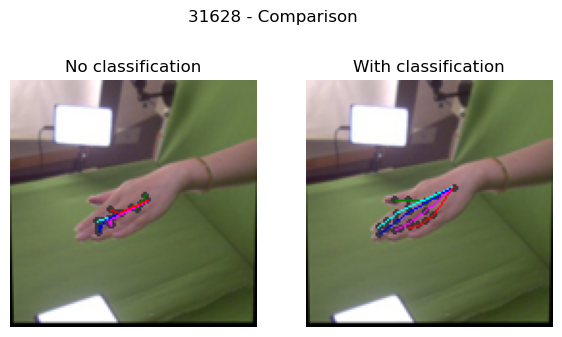

Hand 31608
No classification error: 4.986794547243992
With classification error: 4.064618546729006


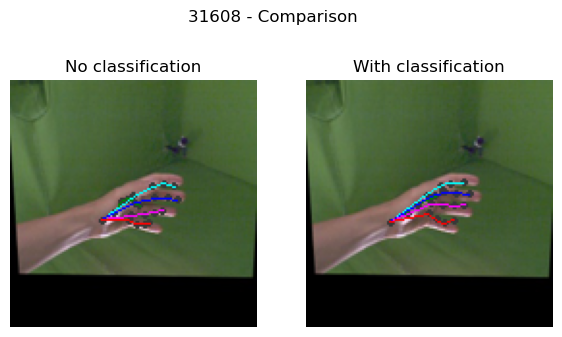

In [10]:
for best_idx in best_10:
    model_comparison(idx=best_idx)

### Random samples

Selecting 10 random test images

In [11]:
from random import sample

rand_idx = sample(population=list(range(len(idxs))), k=10) 

Hand 00031880.jpg
No classification error: 8.650911749431465
With classification error: 13.974004900211686


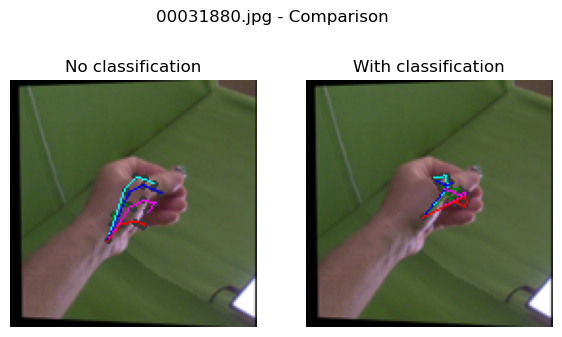

Hand 00031830.jpg
No classification error: 20.286919185025976
With classification error: 10.42918370961564


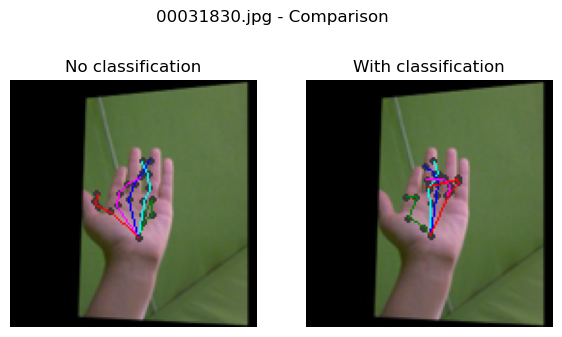

Hand 00032220.jpg
No classification error: 20.103367324712302
With classification error: 25.5719832190864


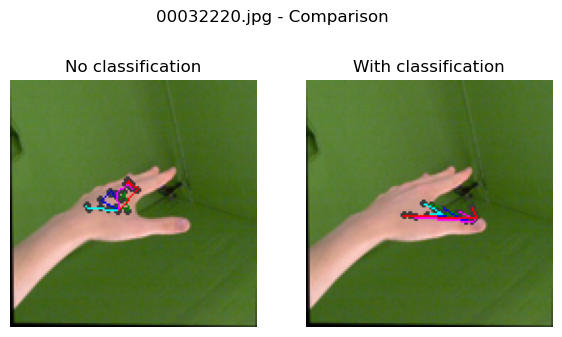

Hand 00031671.jpg
No classification error: 18.842721745472936
With classification error: 10.527382966321248


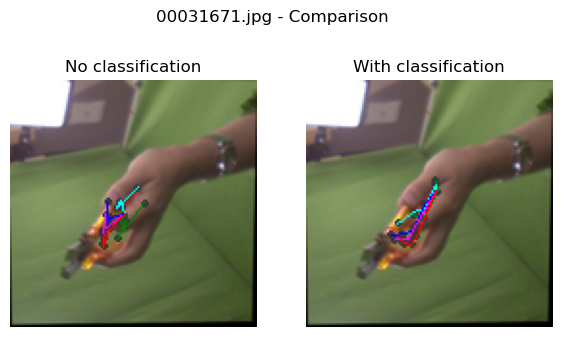

Hand 00031181.jpg
No classification error: 12.058873274245194
With classification error: 17.138122167756734


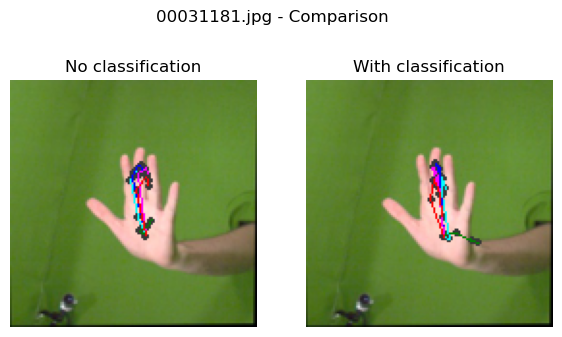

Hand 00032266.jpg
No classification error: 15.556812336239018
With classification error: 17.103861628030717


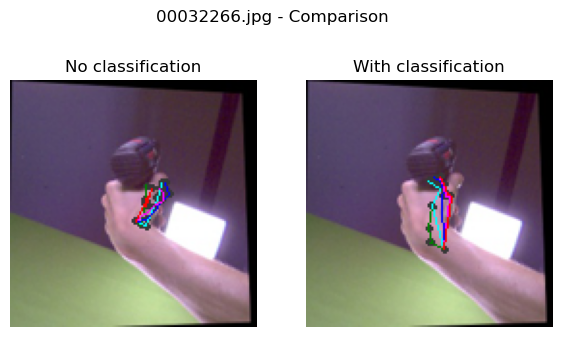

Hand 00031900.jpg
No classification error: 20.28486513223777
With classification error: 13.27924205159161


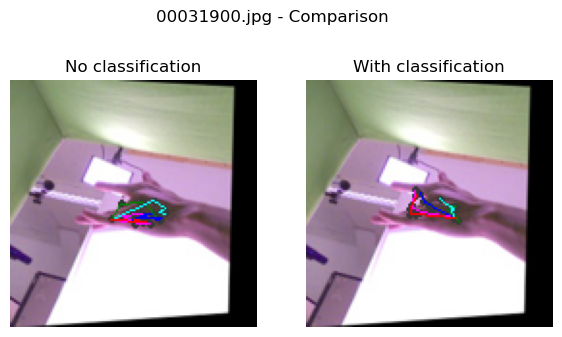

Hand 00031231.jpg
No classification error: 19.34416675691092
With classification error: 14.297345256701993


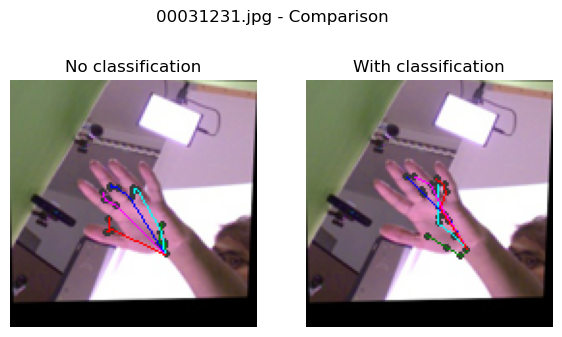

Hand 00031997.jpg
No classification error: 14.775829926230383
With classification error: 11.153348884709963


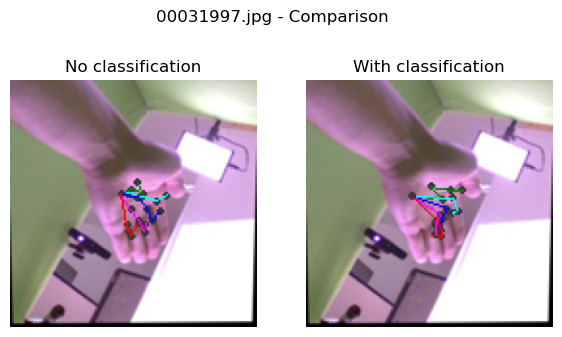

Hand 00031560.jpg
No classification error: 10.566022701877396
With classification error: 13.335167719122778


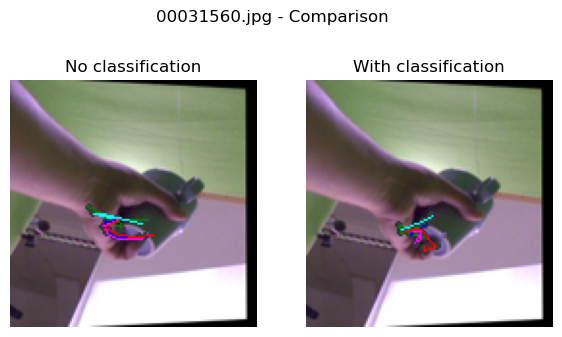

In [12]:
for idx in rand_idx:
    model_comparison(idx=idx)